In [1]:
%pip install matplotlib numpy tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 33.6 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 33.6 MB/s  0:00:00m0:00:0100:01
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 40.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9/9 [matplotlib]9 [matplotlib]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
from tqdm import tqdm
np.random.seed(1234)

# Individuals

In [16]:
class Individual:

    def __init__(self, n: int):
        self.genes = np.random.randint(0, 2, (n,))
        self.fitness = -np.inf

    def __str__(self):
        return f'(Ind: {self.genes}, {self.fitness})'

    def __repr__(self):
        return str(self)

Define Individual with n = 20

In [17]:
ind = Individual(20)

Define Evaluate and Mutate Functions

In [19]:
#  Define One Max and Leading Ones functions
def onemax(i: Individual):
    return np.sum(i.genes)

def leading_ones(ind: Individual):
    f = 0
    for i in range(len(ind.genes)):
        if not ind.genes[i]:
            f = i
            break
        if i == len(ind.genes) - 1:
            f = len(ind.genes)
    return f

def evaluate(ind: Individual, objective):
    ind.fitness = objective(ind)

def mutate(ind: Individual, mutation_rate=1.0/len(ind.genes)):
    new_genes = np.copy(ind.genes)
    for i in range(len(new_genes)):
        if np.random.rand() < mutation_rate:
            new_genes[i] = not ind.genes[i]
    child = Individual(len(ind.genes))
    child.genes = new_genes
    return child

Define (1+1)-EA and (1+λ)-EA 

In [23]:
def one_plus_one(ind_length: int, num_generations: int, objective):
    fits = np.zeros(num_generations)
    parent = Individual(ind_length)
    evaluate(parent, objective)

    for i in (range(len(fits))):
        child = mutate(parent)
        evaluate(child, objective)

        if child.fitness >= parent.fitness:
            parent = child

        fits[i] = parent.fitness
    return fits

def one_plus_lambda(ind_length: int, num_generations: int, objective, 𝜆: int):
    fits = np.zeros(num_generations)
    parent = Individual(ind_length)
    evaluate(parent, objective)

    for i in (range(len(fits))):
        population = [parent,]
        best = 0
        for j in range(1, 𝜆):
            population.append(mutate(parent))
            evaluate(population[j], objective)
            if population[j].fitness > population[best].fitness:
                best = j
        if population[best].fitness >= parent.fitness:
            parent = population[best]
        fits[i] = parent.fitness
    return fits

Running trials 10 times for one_plus_one and one_plus_lamda

In [136]:
n = 20
expected_generations = int(np.round(np.e * n * np.log(n)))  # e * n log n
min_num_generations = expected_generations // 2             # lower bound
max_num_generations = expected_generations * 5             # generous upper bound

print(f'Expected runtime (theory): {expected_generations}')
print(f'Min number of generations: {min_num_generations}')
print(f'Max number of generations: {max_num_generations}')

Expected runtime (theory): 163
Min number of generations: 81
Max number of generations: 815


In [151]:
n_trials = 10
lamda = int(round(np.log(n)*np.log(np.log(n))/np.log(np.log(np.log(n)))))
print(f'λ = {lamda}')
gen_range = range(100, 801, 100)  # 100, 200, ..., 800
print(f'Generation range: {list(gen_range)}')

λ = 35
Generation range: [100, 200, 300, 400, 500, 600, 700, 800]


Kết quả thực nghiệm với n=20

Cả hai bài toán OneMax và LeadingOnes đều có nghiệm tối ưu là chuỗi 20 bit 1. Chúng ta chạy 
(1+1) và (1+1)-EA (với λ được chọn theo công thức lý thuyết) trong nhiều số thế hệ 
n_gens
∈
{
100, 200, 300,..,700, 800}, mỗi cấu hình lặp lại 10 lần.

Tỉ lệ thành công (số lần đạt nghiệm tối ưu / 10 lần chạy)

# 3. Find the number of generations

In [165]:
def find_stable_gen(objective):
   # track success
    success_1 = {}
    success_lam = {}
    #for plotting
    fits_1 = {}     # dict: key = n_gens, value = (n_gens, n_trials) array
    fits_lam = {}   # dict: key = n_gens, value = (n_gens//lamda, n_trials) array

    for n_gens in gen_range:
        count_1 = 0
        count_lam = 0
        fits_1[n_gens] = np.zeros((n_gens, n_trials))
        fits_lam[n_gens] = np.zeros((n_gens // lamda, n_trials))

        for i in range(n_trials):
            # run (1+1)-EA
            fits1 = one_plus_one(n, n_gens, objective)
            fits_1[n_gens][:, i] = fits1                # ✅ store trajectory
            if np.max(fits1) == n:   # optimum found
                count_1 += 1

            # run (1+λ)-EA
            fitslam = one_plus_lambda(n, n_gens // lamda, objective, lamda)
            fits_lam[n_gens][:, i] = fitslam            # ✅ store trajectory
            if np.max(fitslam) == n: # optimum found
                count_lam += 1

        success_1[n_gens] = count_1
        success_lam[n_gens] = count_lam

    # print results
    print("\n=== Success counts (out of 10) ===")
    for n_gens in gen_range:
        print(f"Generations {n_gens}: (1+1)-EA {success_1[n_gens]}/10, (1+λ)-EA {success_lam[n_gens]}/10")

    # find stable cutoff (≥7/10)
    def find_stable(success_dict):
        for gens, count in success_dict.items():
            if count >= 7:
                return gens
        return None

    stable_1 = find_stable(success_1)
    stable_lam = find_stable(success_lam)

    print(f"\n=== Stable generation counts (≥7/10 success) for {objective.__name__} ===")
    print(f"(1+1)-EA: {stable_1 if stable_1 else 'not reached in range'}")
    print(f"(1+λ)-EA: {stable_lam if stable_lam else 'not reached in range'}")

find_stable_gen(onemax)
find_stable_gen(leading_ones)


=== Success counts (out of 10) ===
Generations 100: (1+1)-EA 2/10, (1+λ)-EA 0/10
Generations 200: (1+1)-EA 9/10, (1+λ)-EA 0/10
Generations 300: (1+1)-EA 10/10, (1+λ)-EA 5/10
Generations 400: (1+1)-EA 10/10, (1+λ)-EA 10/10
Generations 500: (1+1)-EA 10/10, (1+λ)-EA 10/10
Generations 600: (1+1)-EA 10/10, (1+λ)-EA 10/10
Generations 700: (1+1)-EA 10/10, (1+λ)-EA 10/10
Generations 800: (1+1)-EA 10/10, (1+λ)-EA 10/10

=== Stable generation counts (≥7/10 success) for onemax ===
(1+1)-EA: 200
(1+λ)-EA: 400

=== Success counts (out of 10) ===
Generations 100: (1+1)-EA 0/10, (1+λ)-EA 0/10
Generations 200: (1+1)-EA 3/10, (1+λ)-EA 0/10
Generations 300: (1+1)-EA 6/10, (1+λ)-EA 1/10
Generations 400: (1+1)-EA 6/10, (1+λ)-EA 2/10
Generations 500: (1+1)-EA 9/10, (1+λ)-EA 5/10
Generations 600: (1+1)-EA 9/10, (1+λ)-EA 7/10
Generations 700: (1+1)-EA 10/10, (1+λ)-EA 10/10
Generations 800: (1+1)-EA 10/10, (1+λ)-EA 9/10

=== Stable generation counts (≥7/10 success) for leading_ones ===
(1+1)-EA: 500
(1+λ)-EA

Số thế hệ ổn định (≥ 7/10 lần chạy đạt nghiệm tối ưu)

(
1
+
1
)
(1+1)-EA: 200 thế hệ cho OneMax

(
1
+
𝜆
)
(1+λ)-EA: 400 thế hệ cho OneMax

Số thế hệ ổn định (≥ 7/10 lần chạy đạt nghiệm tối ưu)

(
1
+
1
)
(1+1)-EA: 500 thế hệ cho LeadingOne

(
1
+
𝜆
)
(1+λ)-EA: 600 thế hệ cho LeadingOne

# 4. Draw convergence graph with X axis represents the number of evaluations

In [167]:
def one_plus_one_eval(ind_length: int, num_generations: int, objective):
    fits = np.zeros(num_generations)
    evals = np.zeros(num_generations)  # track cumulative evaluations
    
    parent = Individual(ind_length)
    evaluate(parent, objective)
    eval_count = 1  # initial parent evaluated
    
    for i in range(len(fits)):
        child = mutate(parent)
        evaluate(child, objective)
        eval_count += 1   # one evaluation per generation
        
        if child.fitness >= parent.fitness:
            parent = child

        fits[i] = parent.fitness
        evals[i] = eval_count
    
    return fits, evals


def one_plus_lambda_eval(ind_length: int, num_generations: int, objective, 𝜆: int):
    fits = np.zeros(num_generations)
    evals = np.zeros(num_generations)  # track cumulative evaluations
    
    parent = Individual(ind_length)
    evaluate(parent, objective)
    eval_count = 1  # initial parent evaluated

    for i in range(len(fits)):
        population = [parent,]
        best = 0
        # generate λ-1 offspring
        for j in range(1, 𝜆):
            population.append(mutate(parent))
            evaluate(population[j], objective)
            eval_count += 1  # one evaluation per offspring
            if population[j].fitness > population[best].fitness:
                best = j

        # replacement
        if population[best].fitness >= parent.fitness:
            parent = population[best]

        fits[i] = parent.fitness
        evals[i] = eval_count
    
    return fits, evals

In [ ]:
def draw_convergence_graph(objective, n_gens_1, n_gens_λ,     lam = 35):
    n = 20
    n_trials = 10

    # run multiple trials
    fits_1_all, evals_1_all = [], []
    fits_λ_all, evals_λ_all = [], []

    # run multiple trials
    for i in range(n_trials):
        f1, e1 = one_plus_one_eval(n, n_gens_1, objective)
        fλ, eλ = one_plus_lambda_eval(n, n_gens_λ, objective, lamda)

        fits_1_all.append(f1)
        evals_1_all.append(e1)
        fits_λ_all.append(fλ)
        evals_λ_all.append(eλ)

    # convert to numpy
    fits_1_all = np.array(fits_1_all)   # shape: (trials, generations)
    evals_1_all = np.array(evals_1_all)

    fits_λ_all = np.array(fits_λ_all)
    evals_λ_all = np.array(evals_λ_all)

    # compute mean ± std
    μ_1 = np.mean(fits_1_all, axis=0)
    σ_1 = np.std(fits_1_all, axis=0)
    x_1 = np.mean(evals_1_all, axis=0)  # evaluations axis

    μ_λ = np.mean(fits_λ_all, axis=0)
    σ_λ = np.std(fits_λ_all, axis=0)
    x_λ = np.mean(evals_λ_all, axis=0)
    # plot
    plt.figure(figsize=(8,5))
    plt.plot(x_1, μ_1, label="(1+1)-EA", color='b')
    plt.fill_between(x_1, μ_1+σ_1, μ_1-σ_1, facecolor='b', alpha=0.1)

    plt.plot(x_λ, μ_λ, label="(1+λ)-EA", color='g')
    plt.fill_between(x_λ, μ_λ+σ_λ, μ_λ-σ_λ, facecolor='g', alpha=0.1)

    plt.xlabel("Evaluations")
    plt.ylabel("Fitness")
    plt.title(f"OneMax on {n} Dimensions — Convergence over {n_trials} trails")
    plt.legend()
    plt.show()

    first_hit_1 = []
    first_hit_λ = []

    for trial in range(n_trials):
        # (1+1)-EA
        f1 = fits_1_all[trial]
        e1 = evals_1_all[trial]

        hit_idx_1 = np.argmax(f1 == n)  # first index where fitness == n
        if f1[hit_idx_1] == n:
            first_hit_1.append(e1[hit_idx_1])
        else:
            first_hit_1.append(None)  # did not converge

        # (1+λ)-EA
        fλ = fits_λ_all[trial]
        eλ = evals_λ_all[trial]

        hit_idx_λ = np.argmax(fλ == n)
        if fλ[hit_idx_λ] == n:
            first_hit_λ.append(eλ[hit_idx_λ])
        else:
            first_hit_λ.append(None)

    # convert to numpy for stats
    first_hit_1 = np.array([x for x in first_hit_1 if x is not None])
    first_hit_λ = np.array([x for x in first_hit_λ if x is not None])

    print(f"=== (1+1)-EA for {objective.__name__} ===")
    print("Total evaluations per run:", evals_1_all[0, -1])
    print("First hitting times (evals):", first_hit_1)

    print(f"\n=== (1+λ)-EA for {objective.__name__} ===")
    print("Total evaluations per run:", evals_λ_all[0, -1])
    print("First hitting times (evals):", first_hit_λ)

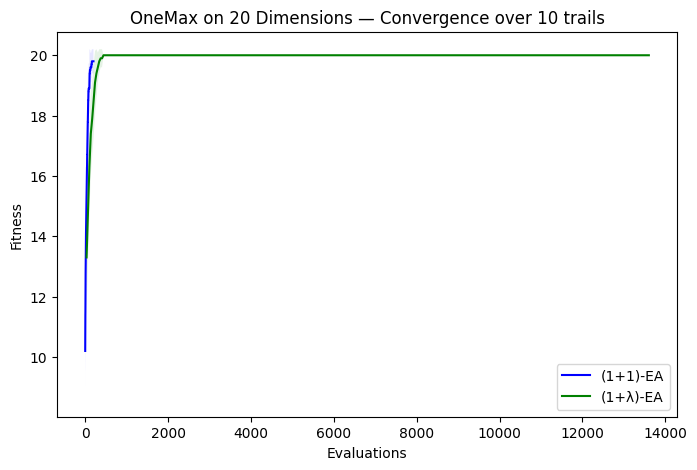

=== (1+1)-EA for onemax ===
Total evaluations per run: 201.0
First hitting times (evals): [104. 150.  64. 161. 103. 105.  84.  78.]

=== (1+λ)-EA for onemax ===
Total evaluations per run: 13601.0
First hitting times (evals): [205. 443. 273. 239. 205. 205. 341. 341. 375. 239.]


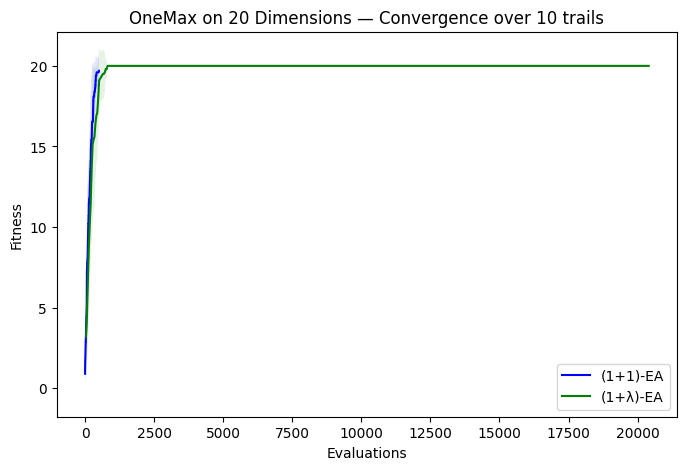

=== (1+1)-EA for leading_ones ===
Total evaluations per run: 501.0
First hitting times (evals): [291. 379. 251. 331. 252. 393. 495. 202. 370.]

=== (1+λ)-EA for leading_ones ===
Total evaluations per run: 20401.0
First hitting times (evals): [511. 511. 511. 273. 239. 647. 273. 817. 239. 477.]


In [171]:
draw_convergence_graph(onemax, 200, 400)
draw_convergence_graph(leading_ones, 500, 600)

# 6. Find minimal lamda

In [175]:
def find_minimal_lambda(objective, n_gens, lam_range, n_trials=10):
    success_lam = {}

    for lam in lam_range:
        count_lam = 0

        for i in range(n_trials):
            fitslam = one_plus_lambda(n, n_gens // lam, objective, lam)
            if np.max(fitslam) == n:  # optimum found
                count_lam += 1

        success_lam[lam] = count_lam
        print(f"λ = {lam}: {count_lam}/{n_trials} successes")

    # find minimal λ with ≥7 successes
    stable_lam = None
    for lam, count in success_lam.items():
        if count >= 7:
            stable_lam = lam
            break

    print(f"\n=== Minimal λ of (1+λ)-EA (≥7/10 success) for {objective.__name__} ===")
    print(f"{objective.__name__}: {stable_lam if stable_lam else 'not found in range'}")
    return stable_lam, success_lam


# Example usage
lam_range = range(2, 36, 2)  # try odd λ from 1 to 50
stable_lam, success_counts = find_minimal_lambda(onemax, n_gens=400, lam_range=lam_range, n_trials=10)
stable_lam, success_counts = find_minimal_lambda(leading_ones, n_gens=600, lam_range=lam_range, n_trials=10)

λ = 2: 9/10 successes
λ = 4: 10/10 successes
λ = 6: 10/10 successes
λ = 8: 10/10 successes
λ = 10: 10/10 successes
λ = 12: 10/10 successes
λ = 14: 10/10 successes
λ = 16: 10/10 successes
λ = 18: 10/10 successes
λ = 20: 10/10 successes
λ = 22: 10/10 successes
λ = 24: 10/10 successes
λ = 26: 7/10 successes
λ = 28: 10/10 successes
λ = 30: 10/10 successes
λ = 32: 10/10 successes
λ = 34: 7/10 successes

=== Minimal λ of (1+λ)-EA (≥7/10 success) for onemax ===
onemax: 2
λ = 2: 3/10 successes
λ = 4: 7/10 successes
λ = 6: 9/10 successes
λ = 8: 10/10 successes
λ = 10: 10/10 successes
λ = 12: 10/10 successes
λ = 14: 10/10 successes
λ = 16: 10/10 successes
λ = 18: 10/10 successes
λ = 20: 8/10 successes
λ = 22: 9/10 successes
λ = 24: 9/10 successes
λ = 26: 7/10 successes
λ = 28: 9/10 successes
λ = 30: 8/10 successes
λ = 32: 6/10 successes
λ = 34: 5/10 successes

=== Minimal λ of (1+λ)-EA (≥7/10 success) for leading_ones ===
leading_ones: 4


# Observations on the Performance of (1+1)-EA and (1+λ)-EA  

## OneMax
- **(1+1)-EA**  
  - Converges reliably when the number of generations is `n_gens = 200`.  
  - Average number of evaluations: about **200**.  
  - First hitting times (evaluations to reach the optimum) are relatively small, ranging from **64 to 161**.  
  - Efficient and straightforward for solving OneMax.  

- **(1+λ)-EA**  
  - Converges reliably when the number of generations is `n_gens = 400`.  
  - Total evaluations are much larger (around **13,601**) because λ offspring are evaluated each generation.  
  - The actual hitting time to optimum is still small (**205 to 443 evaluations**).  
  - Minimal λ to achieve at least 7/10 successful runs: **λ = 2**.  

**Conclusion for OneMax:**  
(1+1)-EA is overall more evaluation-efficient. (1+λ)-EA can succeed with a small λ but becomes expensive in terms of total evaluations.  

---

## LeadingOnes
- **(1+1)-EA**  
  - Needs more generations to converge (`n_gens = 500`).  
  - Average number of evaluations: about **500**.  
  - First hitting times vary between **202 and 495 evaluations**.  
  - Capable of finding the optimum but slower compared to OneMax.  

- **(1+λ)-EA**  
  - Converges reliably when the number of generations is `n_gens = 600`.  
  - Total evaluations are very high (around **20,401**).  
  - Hitting times vary widely, between **239 and 817 evaluations**.  
  - Minimal λ to achieve at least 7/10 successful runs: **λ = 4**.  

**Conclusion for LeadingOnes:**  
(1+1)-EA is more stable and evaluation-efficient. (1+λ)-EA requires many more evaluations and does not show clear improvement.  

---

## Overall Summary
- For **OneMax**, (1+1)-EA is simple and effective, while (1+λ)-EA works with a small λ (λ = 2) but becomes costly when λ grows.  
- For **LeadingOnes**, (1+1)-EA is the better choice. (1+λ)-EA is significantly more evaluation-expensive without notable benefits.  
- Choosing λ in (1+λ)-EA requires care: larger values quickly increase evaluation cost without improving performance.  
